<a href="https://colab.research.google.com/github/richsharples/MIT-DS/blob/main/CapstoneFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install required packages
## Downgrade statsmodels and install basic libraries 

In [1]:
# Downgrading statsmodels as per Great Learning advice
!pip install statsmodels==0.12.1

# Version check 
import statsmodels
statsmodels.__version__

!pip install pmdarima

In [2]:
#Import required packages
import pandas as pd
import sys
import warnings
import itertools
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
#Define a function to test for stationarity us ADF

#Importing adfuller using statsmodels
from statsmodels.tsa.stattools import adfuller

def TestStationarityADF(series, pv_threshold = 0.05):

  print('Dickey-Fuller test results ')
  adfres = adfuller(series)
  pv = adfres[1]
  print('ADF Statistic: \t%.3f' % adfres[0])
  print('p-value: \t%.3f' % pv)  
  print ('Lags used: \t%d' % adfres[2])
  print ('Obvs used: \t%d' % adfres[3])

  print ("Critical Values")
  for key,value in adfres[4].items():
	  print('\t%s: %.3f' % (key, value))
   
  # p-value > pv_threshold: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
  # p-value <= pv_threshold: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

  if (pv > pv_threshold):
    print ("Series is non-stationary")
    print ('Differnces reqd to make stationary: %d' % ndiffs(series))

  else:
    print ("Series is stationary")

## Read the data and prepare it for analysis / modelling

1. convert the YYYYMM column into datetime
2. convert Value to numeric

Build a new DataFrame (mte) containing only natural gas samples.

In [44]:
# Read the data

# uncomment if using Google Drive
from google.colab import drive
drive.mount('/content/drive')

dfname = '/content/drive/MyDrive/MIT-DataServices/Notebooks/Capstone/MER_T12_06.xlsx'

dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')

#We're only interested in the first 3 columns - YYYYMM, MSN, Value
df = pd.read_excel(dfname, 
                parse_dates=['YYYYMM'],
                index_col='YYYYMM', 
                date_parser=dateparse)

df.head() 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,MSN,Value,Description
YYYYMM,,,
1973-01-01,CLEIEUS,72.076,Coal Electric Power Sector CO2 Emissions
1973-02-01,CLEIEUS,64.442,Coal Electric Power Sector CO2 Emissions
1973-03-01,CLEIEUS,64.084,Coal Electric Power Sector CO2 Emissions
1973-04-01,CLEIEUS,60.842,Coal Electric Power Sector CO2 Emissions
1973-05-01,CLEIEUS,61.798,Coal Electric Power Sector CO2 Emissions


In [45]:
###Slice the data to get the monthly total CO2 emissions of Natural Gas Electric Power Sector
 
Emissions = df.iloc[:,1:]   # Monthly total emissions (mte)
Emissions= Emissions.groupby(['Description', pd.Grouper(freq='M')])['Value'].sum().unstack(level = 0)
mte = Emissions['Natural Gas Electric Power Sector CO2 Emissions'] # monthly total emissions (mte)

#convert the emision value into numeric value
 
mte = pd.to_numeric(mte,errors = 'coerce')

# mte - monnthly total emmissions is our baseline data series.

print ( "number of rows", mte.count())
print ( "invalid rows",mte.isnull().sum())

start_date = mte.index[0].strftime("%m/%Y")
end_date = mte.index[mte.count()-1].strftime("%m/%Y")
print ( "time series range %s to %s" %(start_date,end_date))

number of rows 523
invalid rows 0
time series range 01/1973 to 07/2016


# Data Analysis 

1. Some basic analysis of the prepared data included breaking out seasonality and trends.
2. Test for stationarity using ADF


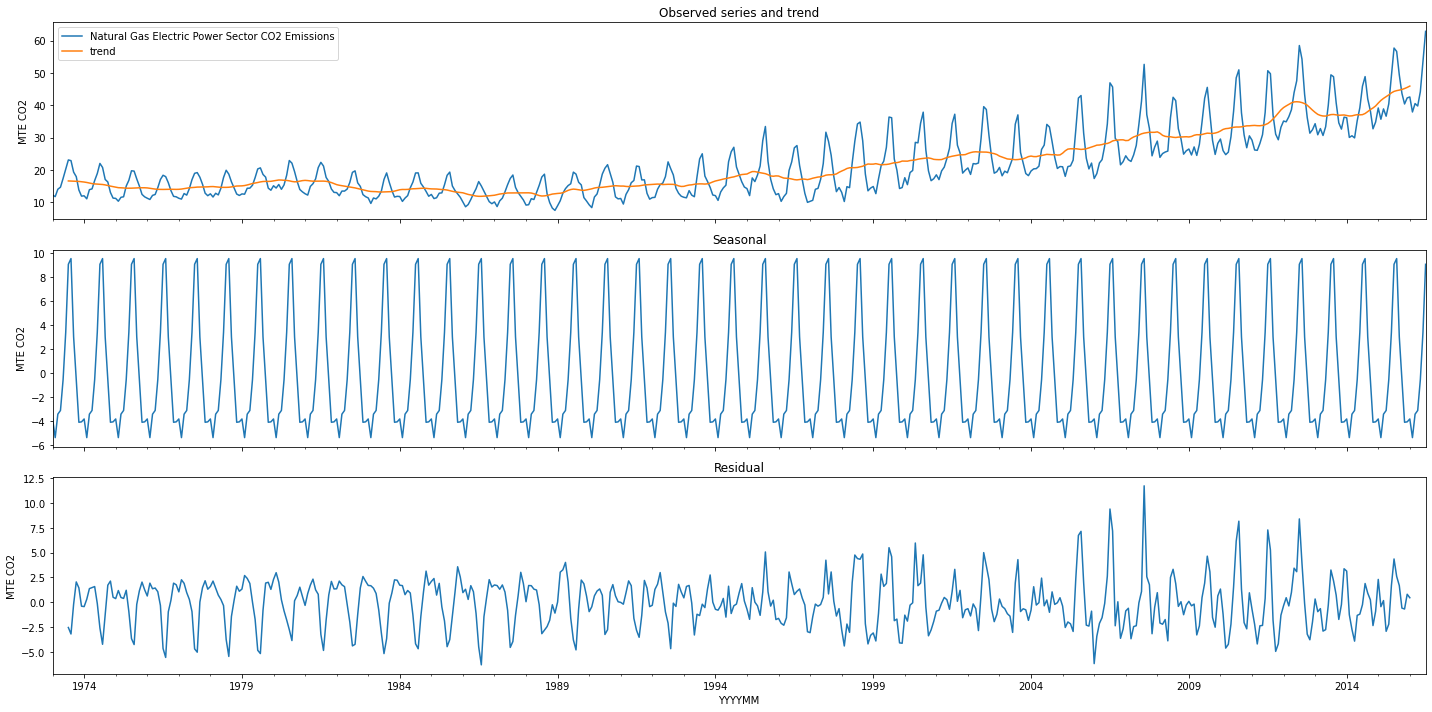


Analysing mte
-------------
Dickey-Fuller test results 
ADF Statistic: 	1.831
p-value: 	0.998
Lags used: 	19
Obvs used: 	503
Critical Values
	1%: -3.443
	5%: -2.867
	10%: -2.570
Series is non-stationary
Differnces reqd to make stationary: 1


In [6]:
#Importing the seasonal_decompose function to decompose the time series
# decompose the orinal time series

from pmdarima.arima import ndiffs, nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(mte)

fig, axes = plt.subplots(3, 1,figsize=(20,10), sharex=True)

axes[0].set_ylabel('MTE CO2')
axes[0].set_title ("Observed series and trend")
decomp.observed.plot(ax=axes[0], legend=True)
decomp.trend.plot(ax=axes[0], legend=True)

axes[1].set_ylabel('MTE CO2')
axes[1].set_title ("Seasonal")
decomp.seasonal.plot(ax=axes[1])

axes[2].set_ylabel('MTE CO2')
axes[2].set_title ("Residual")
decomp.resid.plot(ax=axes[2])

plt.tight_layout()
plt.show()

print ("\nAnalysing mte")
print ("-------------")

TestStationarityADF (mte)

## Observations:

1. There is a clear upward trend starting in 1994
2. There is obvious and consistent **annual** seasonality
3. Time series is not stationary and requires first order differencing 

In [7]:
# Make time-series stationary by first-order differencing

mte_dif = mte.diff()

# Remove the seasonal differnce 

mte_dif = mte.diff(12)

mte_dif.dropna(inplace=True)

TestStationarityADF (mte_dif)

Dickey-Fuller test results 
ADF Statistic: 	-4.412
p-value: 	0.000
Lags used: 	13
Obvs used: 	497
Critical Values
	1%: -3.444
	5%: -2.867
	10%: -2.570
Series is stationary




Now the time series is stationary - we can start to determine 

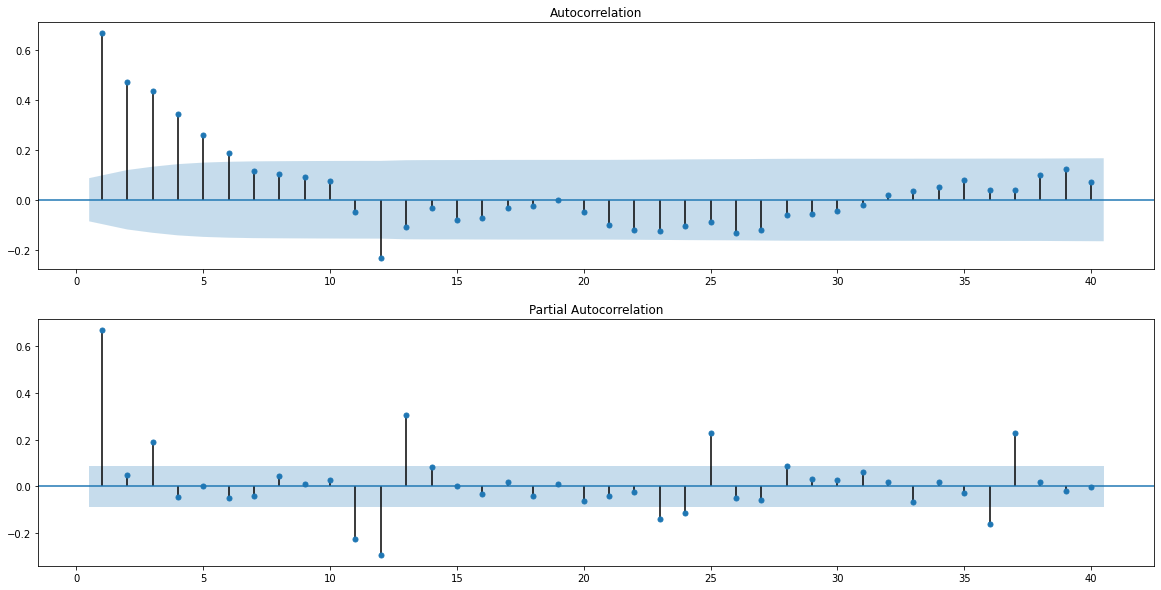

In [8]:
# Plot (P)ACF using log transformed and shifted data
# to find p & q

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

nlags = 40

fig, ax = plt.subplots(2,1,figsize=(20,10))
plot_acf(mte_dif, lags=nlags, ax=ax[0], zero=False)
plot_pacf(mte_dif, lags=nlags, ax=ax[1], zero=False)

plt.show()

##Observations:

**Note : the above ACF and PACF charts start at lag-1**

For ACF - there is a gradually decreasing trend 
For PACF - cuts after lag-1

This suggests AR(1) would be appropriate.

#Modelling

## SARIMA
The SARIMA model () is suitable as it is specifically designed for seasonal time series data. The general form of SARIMA is :

  SARIMA(p,d,q)x(P,D,Q)lag

Where 

* p and seasonal P: indicate the number of AR terms (lags of the stationary series)
* d and seasonal D: indicate differencing that must be done to stationary series
* q and seasonal Q: indicate the number of MA terms (lags of the forecast errors)
* lag: indicates the seasonal length in the data

As a first order estimate we will build a model using:

  SARIMA (1,1,1)x(1,1,1)12




In [49]:
from pyparsing import results
# Function to plot model against time series and show summary results

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

def EvalSARIMA (series, ppdq, pPDQs) :

  model=sm.tsa.statespace.SARIMAX(
          series,
          order=ppdq,
          seasonal_order=pPDQs,
          enforce_stationarity=False,
          enforce_invertibility=False)
    
  results = model.fit() #fit the model

  plt.figure(figsize=(16,8))
  plt.plot(series) 
  plt.plot(results.predict(), color='red')

  titletext = "SARIMA {p} {P} : MSE={mse:.3f}, AIC={aic:.3f}".format (
        p=ppdq, 
        P=pPDQs, 
        mse=mean_squared_error(results.fittedvalues,series, squared=False), 
        aic=results.aic)

  plt.title (titletext)

  plt.show()

  # Plot diagnostics
  results.plot_diagnostics(figsize=(16,10));
 

  return results  

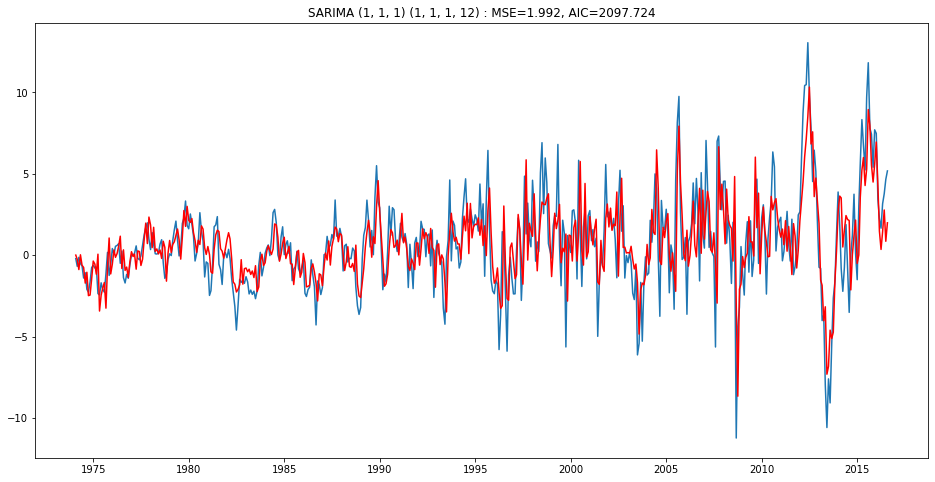

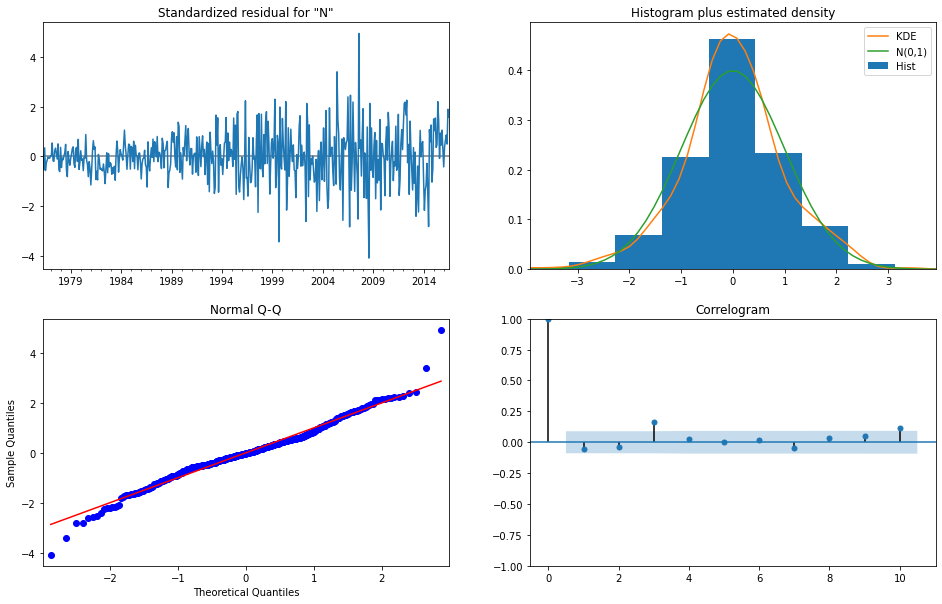

In [50]:
EvalSARIMA (mte_dif,(1,1,1),(1,1,1,12))


## SARIMA Grid Search

While the first order approximation for SARIMA was good, we'll use a grid search to iterate through different combinations of ARIMA combinations to find the best AIC.

In [52]:
# Code inspired by : 
# https://towardsdatascience.com/grid-search-for-sarimax-parameters-adbd5104cb8b
#

warnings.filterwarnings("ignore") # specify to ignore warning messages

#non-seasonal p,d,q can take any value of 0, 1, 2
p = d = q = range(0, 2) 
pdq = list(itertools.product(p, d, q)) 

#seasonal argument
s=12

# Generate all different combinations of seasonal P, D and Q triplets
pdqs = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))] 

results = []

for param in pdq:
    for sparam in pdqs:

        try :
          mod = sm.tsa.statespace.SARIMAX(mte_dif,
                                       order=param,
                                       seasonal_order=sparam,
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)
                                       
          fitres = mod.fit()
          tup = [param,sparam,fitres.aic]
          results.append (tup)
#          DEBUG
#          print ("SARMIMAX", tup)
        except Exception as e:
            print(e)
            continue


 # Convert into dataframe
topresults = pd.DataFrame(results, columns=['pdq', 'PDQs', 'AIC'])

# Sort and return top 3 combinations    
topresults = topresults.sort_values(by=['AIC'],ascending=True)[0:3]

print ( 'Top 3 models')
print (topresults)


Top 3 models
          pdq           PDQs          AIC
57  (1, 1, 1)  (0, 0, 1, 12)  2008.252121
61  (1, 1, 1)  (1, 0, 1, 12)  2010.222044
41  (1, 0, 1)  (0, 0, 1, 12)  2035.478126


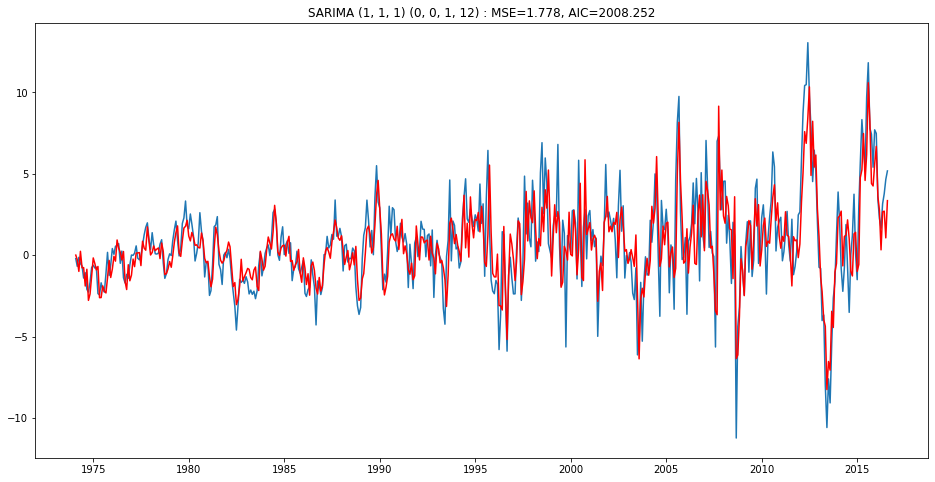

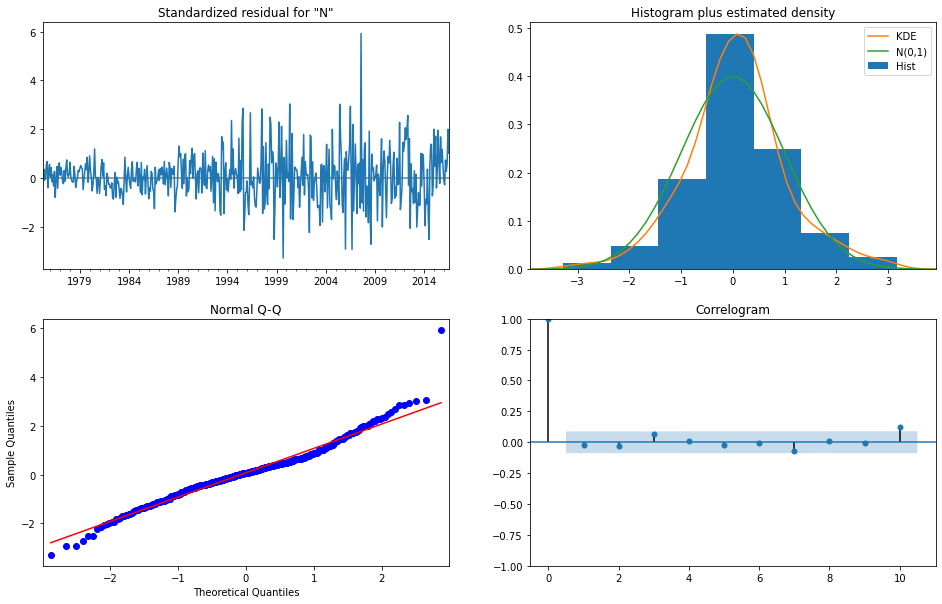

In [53]:
# Plot and evaluate the best model so we can compare it to our manual model

results = EvalSARIMA (mte_dif,(1, 1, 1) , (0, 0, 1, 12))


## Model Evaluation

We will make some prediction within the ime series data to determine how well the model is predicting the trend.

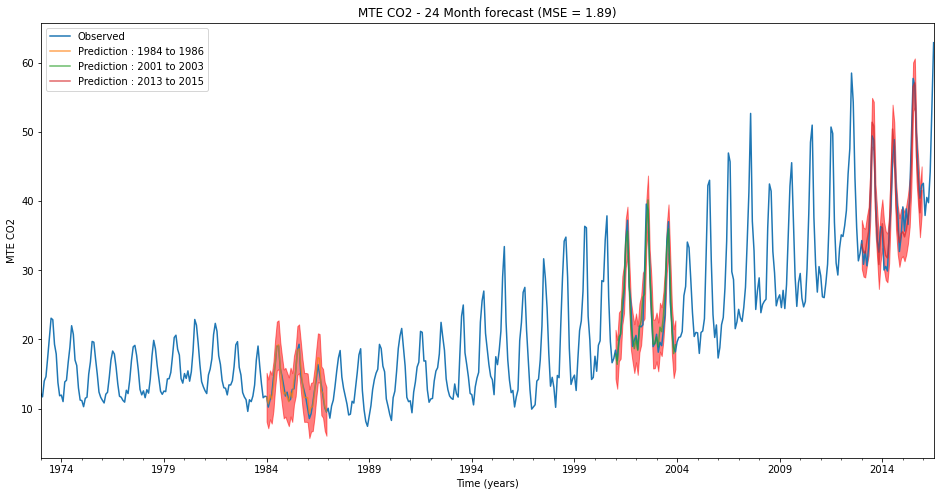

In [36]:


plt.figure(figsize=(16,8))

ax = mte_diff.plot(label='Observed')
ax.set_xlabel('Time (years)')
ax.set_ylabel('MTE CO2')


# Compute the mean square error
mse=mean_squared_error(results.fittedvalues,mte, squared=False)

plt.title('MTE CO2 - 24 Month forecast (MSE = {})'.format(round(mse, 2)))

# Some random 2-year ranges to predict
preds = [['1984','1986'],['2001','2003'],['2013','2015']]

for start_date,end_date in preds :
  pr = results.get_prediction(start = start_date, end = end_date, dynamic=False)

  pr_ci = pr.conf_int()
  pr_ci.head()

  label = "Prediction : {start} to {end}".format(start=start_date,end=end_date) 

  pr.predicted_mean.plot(ax=ax, label=label, alpha=.7)

  ax.fill_between(pr_ci.index,
                pr_ci.iloc[:, 0],
                pr_ci.iloc[:, 1], color='red', alpha=.5)

plt.legend()

plt.show()

# Forecasting

The predictions within the data set seem to be pretty accurate. Now Let's Make some forecasts beyond the end of the data set.

In [37]:
# Get forecast of 2 years or 24 months steps ahead in future
forecast = results.get_forecast(steps = 24)

# Get confidence intervals of forecasts
forecast_ci = forecast.conf_int()
forecast_ci.head()

,lower Natural Gas Electric Power Sector CO2 Emissions,upper Natural Gas Electric Power Sector CO2 Emissions
2016-08-31,58.062560,65.116050
2016-09-30,47.316616,55.987496
2016-10-31,40.736076,50.163096
2016-11-30,36.175928,46.010289
2016-12-31,38.095117,48.172701


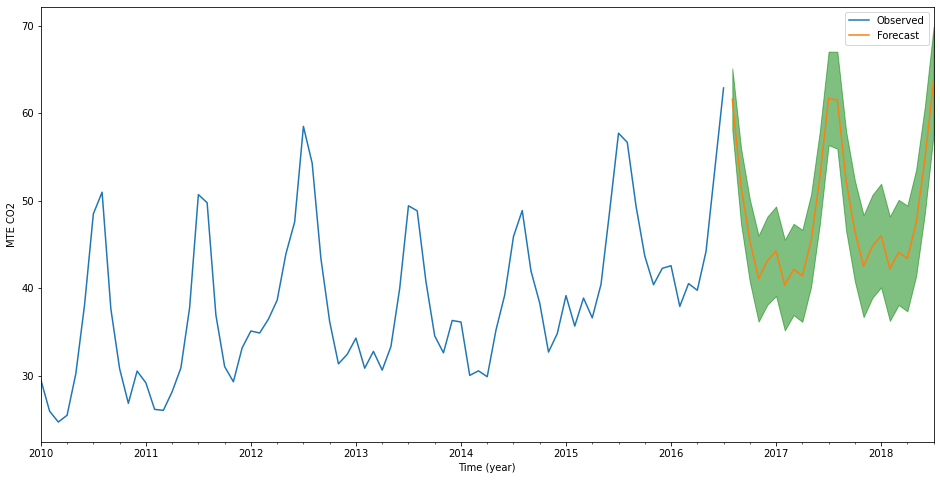

In [43]:
# Ignore date up to 2010 in the plot so we can see the prediction more clearly

ax = mte['2010':].plot(label='Observed', figsize=(16, 8))

forecast.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='green', alpha=.5)

ax.set_xlabel('Time (year)')
ax.set_ylabel('MTE CO2')

plt.legend()
plt.show()